# **E9: Detección de Anomalías con Autoencoder**  

## **Objetivo**  
Implementar un **Autoencoder** para detectar anomalías en datos de consumo energético y meteorología, asegurando que se ejecute eficientemente sin GPU.

## **Datos de entrada**  
Un dataset con las siguientes columnas:  
- **Consumo Energía (kWh)**  
- **Generación FV (kWh)**  
- **Temperatura (°C)**  
- **Radiación Solar (W/m²)**  

---

# **Pasos a seguir**  

## 1. Cargar y visualizar los datos  

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Input, Dense  

# Cargar dataset
df = pd.read_csv("data/m4_datos_energia_canarias.csv", usecols=range(1, 6) )

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')
# Ver las primeras filas
print(df.head())

            Consumo Energía (kWh)  Generación FV (kWh)  Temperatura (°C)  \
Fecha                                                                      
2023-01-01             259.514697           164.004193         20.477757   
2023-01-02             299.305789           173.408325         18.215363   
2023-01-03             307.509279           170.269137         21.074604   
2023-01-04             316.606347           171.587572         16.938845   
2023-01-05             299.377762           158.578316         22.488135   

            Radiación Solar (W/m²)  
Fecha                               
2023-01-01              496.039170  
2023-01-02              504.088217  
2023-01-03              400.357468  
2023-01-04              546.224484  
2023-01-05              517.902633  


In [1]:
df.describe()

NameError: name 'df' is not defined

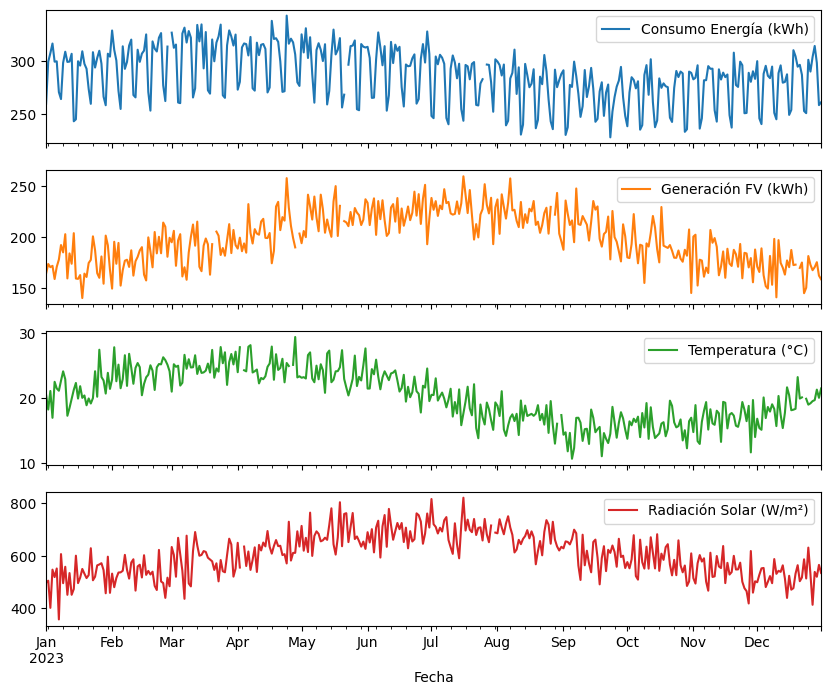

In [ ]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

---

## 2. Preprocesamiento  
- **Rellenar valores nulos**  
- **Normalizar datos** para mejorar la detección  

In [ ]:
# Rellenar valores nulos
df.interpolate(inplace=True)

# Normalización Min-Max
df_normalized = (df - df.min()) / (df.max() - df.min())

# Eliminamos series con baja correlación
df_normalized = df_normalized[['Consumo Energía (kWh)','Temperatura (°C)']]

---

## 3. Entrenar Autoencoder

In [ ]:
# Configuración de TensorFlow para evitar el uso de GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Forzar ejecución en CPU

# Definir la arquitectura del Autoencoder
input_dim = df_normalized.shape[1]  
encoding_dim = 3  # Capa oculta con menor dimensionalidad

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Entrenar el modelo
autoencoder.fit(df_normalized, df_normalized, epochs=100, batch_size=16, shuffle=False, verbose=1)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0875
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0799
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0731
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0671
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0620 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0578
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0543
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0515
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0492
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0473
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0459
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0448
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0438
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0431
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - l

📌 Explicación:

 - encoding_dim=3 → Reduce la dimensión de los datos para detectar patrones.
 - loss="mse" → Minimiza el error cuadrático medio entre entrada y salida.
 - batch_size=16 → Tamaño pequeño para evitar alto consumo de RAM.
 - os.environ["CUDA_VISIBLE_DEVICES"] = "-1" → Forza el uso de CPU.

### 3.1. Almacenar modelo

In [ ]:
# Guardar modelo en disco
autoencoder.save("models/autoencoder_model.h5")
print("Modelo guardado en disco como 'autoencoder_model.h5'")


Modelo guardado en disco como 'autoencoder_model.h5'


### 3.2 Cargar modelo

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Definir la función de pérdida explícitamente
mse = MeanSquaredError()

# Cargar modelo asegurando que reconoce la función de pérdida
autoencoder_loaded = load_model("models/autoencoder_model.h5", compile=False)

# Compilar el modelo cargado
autoencoder_loaded.compile(optimizer="adam", loss=mse)

print("Modelo cargado y recompilado exitosamente.")


Modelo cargado y recompilado exitosamente.


---

## 4. Detección de anomalías

In [ ]:
# Obtener reconstrucciones del Autoencoder
reconstructions = autoencoder.predict(df_normalized)

# Calcular error de reconstrucción
mse = np.mean(np.power(df_normalized - reconstructions, 2), axis=1)

# Definir umbral para anomalías (percentil 95)
threshold = np.percentile(mse, 95)

# Etiquetar anomalías
df["Anomaly"] = mse > threshold

# Mostrar conteo de anomalías detectadas
print(df["Anomaly"].value_counts())


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Anomaly
False    346
True      19
Name: count, dtype: int64


In [ ]:
# Contar el número total de anomalías detectadas
num_anomalies = (df["Anomaly"] == True).sum()
print(f"Número total de anomalías detectadas: {num_anomalies}")


Número total de anomalías detectadas: 19


---

## 4. Visualizar anomalías  

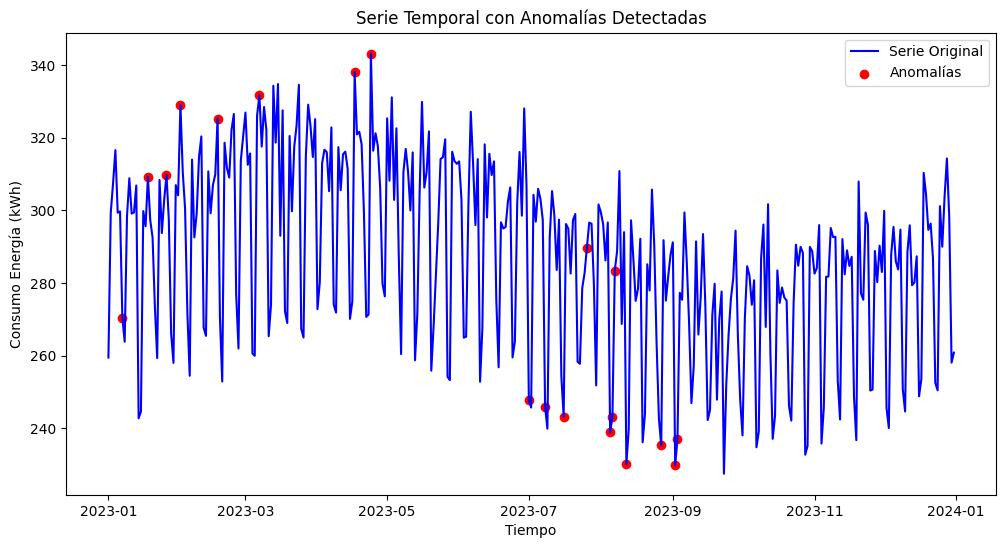

In [ ]:
# 5️⃣ Gráfico de línea con anomalías
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Consumo Energía (kWh)"], label="Serie Original", color="blue")
plt.scatter(df.index[df["Anomaly"] == True], df["Consumo Energía (kWh)"][df["Anomaly"] == True],
            color='red', label='Anomalías', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie Temporal con Anomalías Detectadas")
plt.legend()
plt.show()

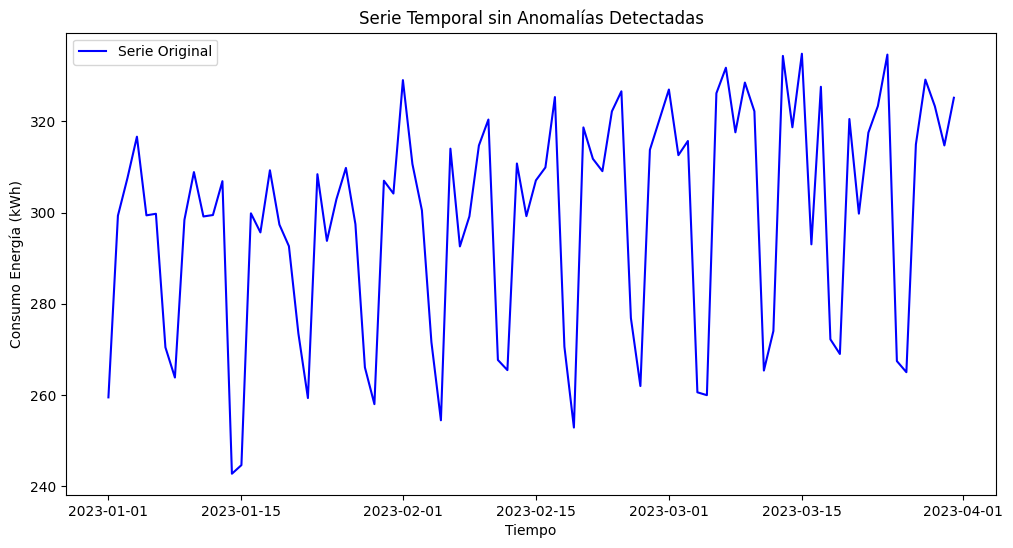

In [ ]:
# Aumentamos el zoom en el primer trimestre
plot_df = df[df.index.month < 4]
# 5️⃣ Gráfico de línea con anomalías
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energía (kWh)"], label="Serie Original", color="blue")
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie Temporal sin Anomalías Detectadas")
plt.legend()
plt.show()

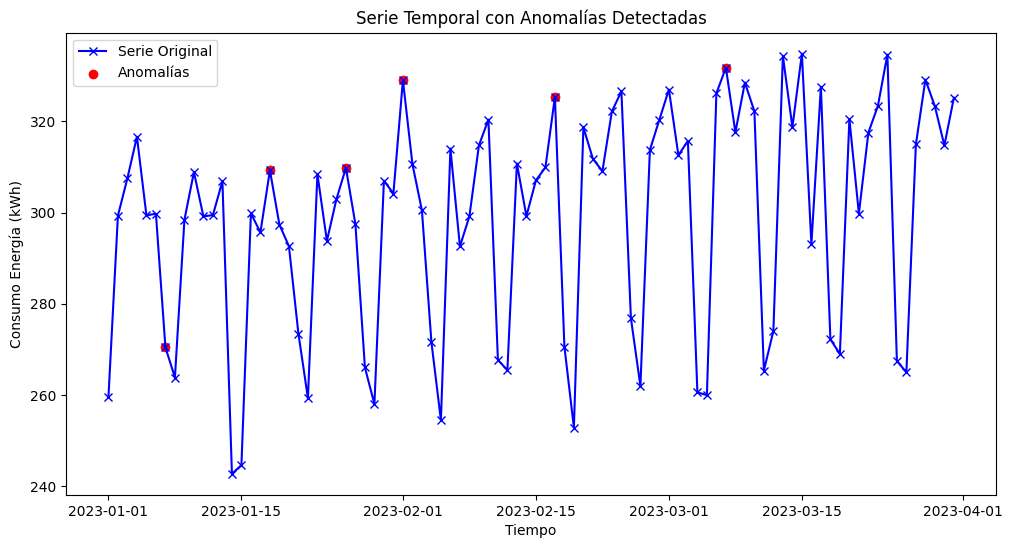

In [ ]:
# 5️⃣ Gráfico de línea con anomalías
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energía (kWh)"], label="Serie Original", color="blue", marker="x")
plt.scatter(plot_df.index[plot_df["Anomaly"]], plot_df["Consumo Energía (kWh)"][plot_df["Anomaly"]],  
            color='red', label='Anomalías', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie Temporal con Anomalías Detectadas")
plt.legend()
plt.show()

---

# **Conclusión**  
- Autoencoder permite detectar anomalías analizando diferencias en la reconstrucción de datos normales.
- Sin necesidad de GPU, este enfoque sigue siendo eficiente con tamaños de batch pequeños y menos neuronas.
- Extensión: Probar diferentes valores de encoding_dim o umbrales de detección.